In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from torchvision import datasets, transforms, models
import sys, os

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from glob import glob
import imageio


In [2]:
!wget -nc https://archive.org/download/food-5-k/Food-5K.zip

--2025-06-30 20:06:56--  https://archive.org/download/food-5-k/Food-5K.zip
Resolving archive.org (archive.org)... 207.241.224.2
Connecting to archive.org (archive.org)|207.241.224.2|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://ia801606.us.archive.org/13/items/food-5-k/Food-5K.zip [following]
--2025-06-30 20:06:57--  https://ia801606.us.archive.org/13/items/food-5-k/Food-5K.zip
Resolving ia801606.us.archive.org (ia801606.us.archive.org)... 207.241.228.126
Connecting to ia801606.us.archive.org (ia801606.us.archive.org)|207.241.228.126|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 447001986 (426M) [application/zip]
Saving to: ‘Food-5K.zip’

Food-5K.zip         100%[===================>] 426.29M  11.7MB/s    in 32s     

2025-06-30 20:07:30 (13.2 MB/s) - ‘Food-5K.zip’ saved [447001986/447001986]



In [3]:
!unzip --qq -o Food-5K.zip

In [4]:
!ls

Food-5K  Food-5K.zip  __MACOSX	sample_data


In [5]:
!ls Food-5K/training

0_0.jpg     0_1387.jpg	0_422.jpg  0_809.jpg   1_1195.jpg  1_230.jpg  1_617.jpg
0_1000.jpg  0_1388.jpg	0_423.jpg  0_80.jpg    1_1196.jpg  1_231.jpg  1_618.jpg
0_1001.jpg  0_1389.jpg	0_424.jpg  0_810.jpg   1_1197.jpg  1_232.jpg  1_619.jpg
0_1002.jpg  0_138.jpg	0_425.jpg  0_811.jpg   1_1198.jpg  1_233.jpg  1_61.jpg
0_1003.jpg  0_1390.jpg	0_426.jpg  0_812.jpg   1_1199.jpg  1_234.jpg  1_620.jpg
0_1004.jpg  0_1391.jpg	0_427.jpg  0_813.jpg   1_119.jpg   1_235.jpg  1_621.jpg
0_1005.jpg  0_1392.jpg	0_428.jpg  0_814.jpg   1_11.jpg    1_236.jpg  1_622.jpg
0_1006.jpg  0_1393.jpg	0_429.jpg  0_815.jpg   1_1200.jpg  1_237.jpg  1_623.jpg
0_1007.jpg  0_1394.jpg	0_42.jpg   0_816.jpg   1_1201.jpg  1_238.jpg  1_624.jpg
0_1008.jpg  0_1395.jpg	0_430.jpg  0_817.jpg   1_1202.jpg  1_239.jpg  1_625.jpg
0_1009.jpg  0_1396.jpg	0_431.jpg  0_818.jpg   1_1203.jpg  1_23.jpg   1_626.jpg
0_100.jpg   0_1397.jpg	0_432.jpg  0_819.jpg   1_1204.jpg  1_240.jpg  1_627.jpg
0_1010.jpg  0_1398.jpg	0_433.jpg  0_81.jpg    1_1205.j

/tmp/ipython-input-6-3985382418.py:1: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  plt.imshow(imageio.imread('Food-5K/training/1_1147.jpg'))


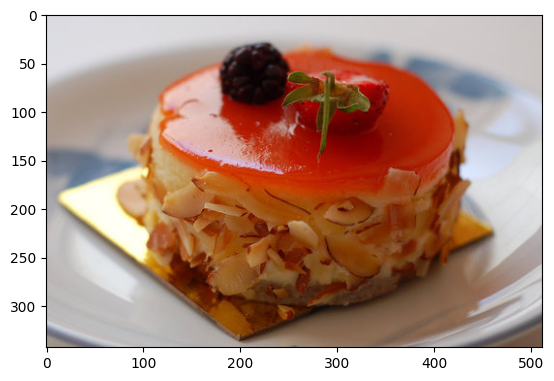

In [6]:
plt.imshow(imageio.imread('Food-5K/training/1_1147.jpg'))

/tmp/ipython-input-7-1856082471.py:1: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  plt.imshow(imageio.imread('Food-5K/training/0_808.jpg'))


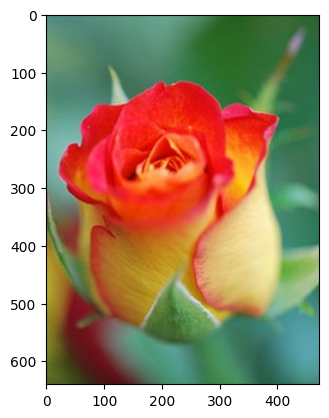

In [7]:
plt.imshow(imageio.imread('Food-5K/training/0_808.jpg'))

In [8]:
!mkdir data

!mkdir data/train
!mkdir data/test
!mkdir data/train/nonfood
!mkdir data/train/food
!mkdir data/test/nonfood
!mkdir data/test/food


In [9]:
!mv Food-5K/training/0*.jpg data/train/nonfood
!mv Food-5K/training/1*.jpg data/train/food
!mv Food-5K/validation/0*.jpg data/test/nonfood
!mv Food-5K/validation/1*.jpg data/test/food


In [11]:
transform = transforms.Compose([
    transforms.Resize(size=256,),
    transforms.CenterCrop(size=224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [12]:
train_dataset = datasets.ImageFolder(
    'data/train',
    transform=transform
)

test_dataset = datasets.ImageFolder(
    'data/test',
    transform=transform
)

In [13]:
batch_size = 128
train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True
)

test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=batch_size
)

model = models.vgg16(pretrained=True)



/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:06<00:00, 87.6MB/s]


In [31]:
test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=batch_size
)

In [14]:
print(model)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [ ]:
model.classifier


Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU(inplace=True)
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=4096, out_features=4096, bias=True)
  (4): ReLU(inplace=True)
  (5): Dropout(p=0.5, inplace=False)
  (6): Linear(in_features=4096, out_features=1000, bias=True)
)

In [15]:
class VGGFeatures(nn.Module):
  def __init__(self, vgg):
    super().__init__()
    self.vgg = vgg

  def forward(self, X):
    out = self.vgg.features(X)
    out = self.vgg.avgpool(out)
    out = out.view(out.size(0), -1) #flatten
    return out



In [18]:
vgg_food = VGGFeatures(model)
print(vgg_food)

VGGFeatures(
  (vgg): VGG(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): ReLU(inplace=True)
      (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): ReLU(inplace=True)
      (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): ReLU(inplace=True)
      (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (15): ReLU(inplace=True)
      (16)

In [20]:
out = vgg_food(torch.rand(1, 3, 224, 224))
out.shape

torch.Size([1, 25088])

In [22]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)
vgg_food.to(device)

cpu


VGGFeatures(
  (vgg): VGG(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): ReLU(inplace=True)
      (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): ReLU(inplace=True)
      (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): ReLU(inplace=True)
      (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (15): ReLU(inplace=True)
      (16)

In [23]:
Ntrain = len(train_dataset)
Ntest = len(test_dataset)
Ntrain, Ntest

(3000, 1000)

In [26]:
D = out.shape[1]

D

25088

In [27]:
X_train = np.zeros((Ntrain, D))
y_train = np.zeros((Ntrain, 1))
X_test = np.zeros((Ntest, D))
y_test = np.zeros((Ntest, 1))

In [29]:
i = 0

with torch.no_grad():
  for inputs, targets in train_loader:

    inputs = inputs.to(device)

    output = vgg_food(inputs)

    sz = len(output)

    X_train[i:i + sz] = output.cpu().detach().numpy()
    y_train[i:i + sz] = targets.view(-1,1).numpy()

    i += sz

    print(i)


128
256
384
512
640
768
896
1024
1152
1280
1408
1536
1664
1792
1920
2048
2176
2304
2432
2560
2688
2816
2944
3000


In [36]:
i = 0

with torch.no_grad():
  for inputs, targets in test_loader:

    inputs = inputs.to(device)

    output = vgg_food(inputs)

    sz = len(output)

    X_test[i:i + sz] = output.cpu().detach().numpy()
    y_test[i:i + sz] = targets.view(-1,1).numpy()

    i += sz

    print(i)

128
256
384
512
640
768
896
1000


In [33]:
X_train.max(), X_train.min()

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_train_2 = scaler.fit_transform(X_train)
X_test_2 = scaler.transform(X_test)


In [35]:
from sklearn.linear_model import LogisticRegression
logr = LogisticRegression()
logr.fit(X_train_2, y_train.flatten())

print("train score:", logr.score(X_train_2, y_train.flatten()))
print("test score:", logr.score(X_test_2, y_test.flatten()))

train score: 1.0
test score: 0.0


In [ ]:
def batch_gd(model, criterion, optimizer, train_loader, test_loader, epochs):
  train_losses = np.zeros(epochs)
  test_losses = np.zeros(epochs)

  for it in range(epochs):
    t0 = datetime.now()
    train_loss = []
    for inputs, targets in train_loader:
       # move data to GPU
       inputs, targets = inputs.to(device), targets.to(device)

        # zero the parameter gradients
       optimizer.zero_grad()

       #Fordward pass

       outputs = model(inputs)
       loss = criterion(outputs, targets)

       loss.backward()
       optimizer.step()

       train_loss.append(loss.item())

    train_loss = np.mean(train_loss)

    test_loss = []
    for inputs, targets in test_loader:
       # move data to GPU
       inputs, targets = inputs.to(device), targets.to(device)

        # zero the parameter gradients
       optimizer.zero_grad()

       #Fordward pass

       outputs = model(inputs)
       loss = criterion(outputs, targets)

       test_loss.append(loss.item())

    test_loss = np.mean(test_loss)

    train_losses[it] = train_loss
    test_losses[it] = test_loss

    dt = datetime.now() - t0

    print(f'Epoch {it}/{epochs}, Train Loss: {train_loss: .4f}, Test Loss: {test_loss} \
     Duration: {dt}')

  return train_losses, test_losses



In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

train_losses, test_losses = batch_gd(
    model,
    criterion,
    optimizer,
    train_loader,
    test_loader,
    epochs=5
)

Epoch 0/5, Train Loss:  0.1377, Test Loss: 0.11635097324324306      Duration: 0:00:50.842757
Epoch 1/5, Train Loss:  0.0342, Test Loss: 0.07421498284202244      Duration: 0:00:50.778057
Epoch 2/5, Train Loss:  0.0370, Test Loss: 0.07255630711370031      Duration: 0:00:49.893368
Epoch 3/5, Train Loss:  0.0215, Test Loss: 0.06695799971930683      Duration: 0:00:50.053480
Epoch 4/5, Train Loss:  0.0092, Test Loss: 0.08315907321230043      Duration: 0:00:50.153108


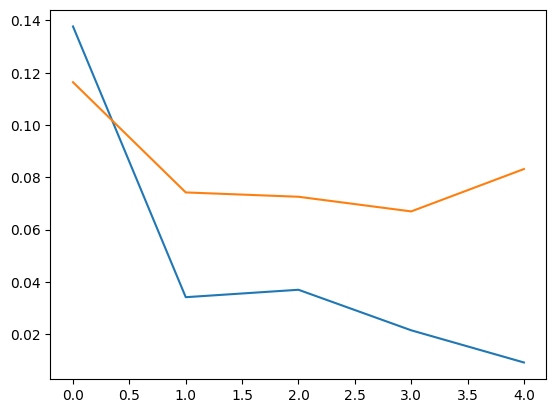

In [ ]:
plt.plot(train_losses, label='train loss')
plt.plot(test_losses, label='test loss')

In [ ]:
n_correct = 0
n_total = 0

for inputs, targets in train_loader:
  inputs, targets = inputs.to(device), targets.to(device)

  outputs = model(inputs)

  _, predictions = torch.max(outputs, 1)

  n_correct += (predictions == targets).sum().item()

  n_total += targets.shape[0]

train_acc = n_correct / n_total


n_correct = 0
n_total = 0

for inputs, targets in test_loader:
  inputs, targets = inputs.to(device), targets.to(device)

  outputs = model(inputs)

  _, predictions = torch.max(outputs, 1)

  n_correct += (predictions == targets).sum().item()

  n_total += targets.shape[0]

test_acc = n_correct / n_total

print(f"Train acc: {train_acc:.4f}, Test acc: {test_acc:.4f}")

Train acc: 0.9937, Test acc: 0.9860
